A code to experiment how to generate a slightly new terrain every time we launch Mangrove.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
import rawpy
import imageio

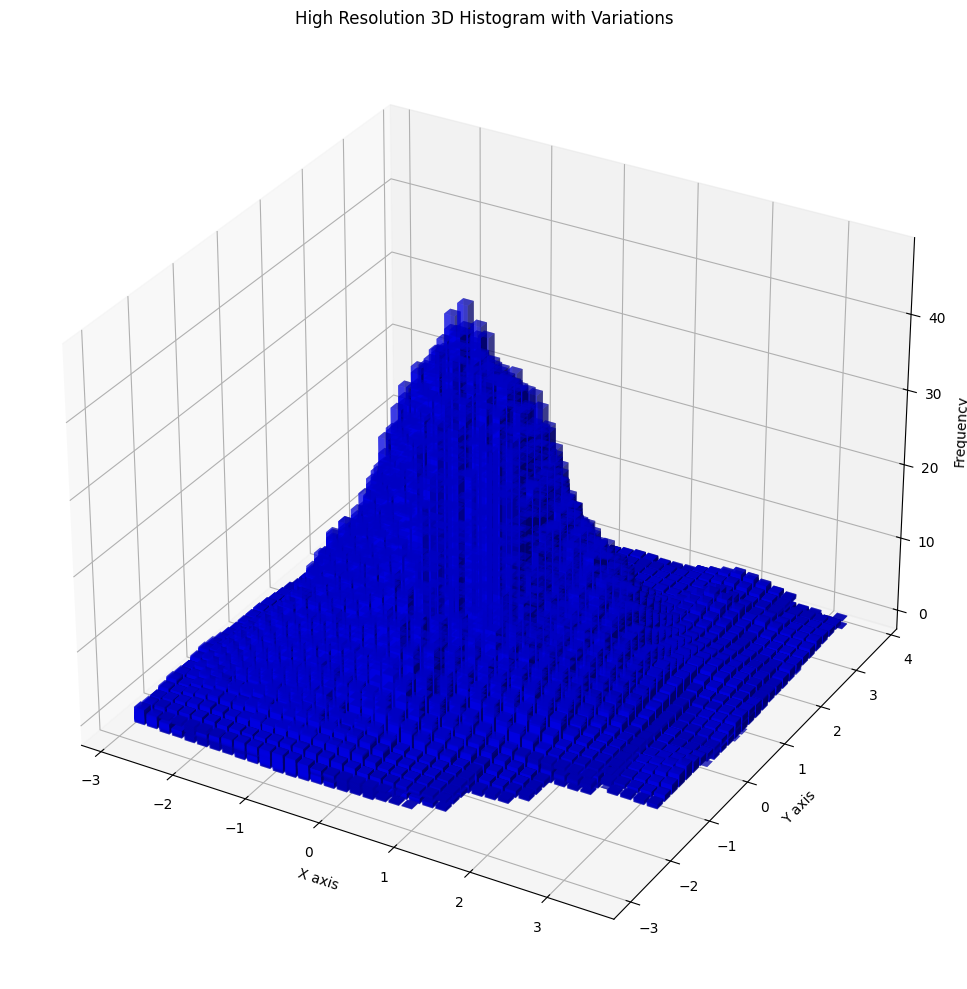

In [6]:
def generate_high_resolution_3d_histogram():
    # Import necessary libraries
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from scipy.interpolate import RegularGridInterpolator
    
    # Generate random data sampling a 3D gaussian distribution
    #data = np.random.multivariate_normal(mean=[0, 0, 0], cov=[[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]], size=1000)
    data = np.random.multivariate_normal(mean=[0, 0, 0], cov=[[1, 0.5, 0], [0.5, 1, 0], [0, 0, 0.25]], size=2000)
    
    # Create original histogram
    hist, edges = np.histogramdd(data, bins=(10, 10, 10))
    
    # Get original bin centers
    x_centers = edges[0][:-1] + (edges[0][1] - edges[0][0]) / 2
    y_centers = edges[1][:-1] + (edges[1][1] - edges[1][0]) / 2
    z_centers = edges[2][:-1] + (edges[2][1] - edges[2][0]) / 2
    
    # Create high-resolution grid with 10x10 points within each original bin
    sub_divisions = 4
    
    # Create the fine grid by interpolating between original bin edges
    x_fine = np.linspace(edges[0][0], edges[0][-1], 10 * sub_divisions)
    y_fine = np.linspace(edges[1][0], edges[1][-1], 10 * sub_divisions)
    z_fine = np.linspace(edges[2][0], edges[2][-1], 10 * sub_divisions)
    
    # Set up interpolation function
    interp_func = RegularGridInterpolator((x_centers, y_centers, z_centers), 
                                          hist,
                                          bounds_error=False,
                                          fill_value=0)
    
    # Prepare coordinate arrays for high-resolution grid
    x_mesh, y_mesh, z_mesh = np.meshgrid(x_fine, y_fine, z_fine, indexing='ij')
    points = np.vstack([x_mesh.flatten(), y_mesh.flatten(), z_mesh.flatten()]).T
    
    # Interpolate values with small random variations
    high_res_values = interp_func(points)
    
    # Add small random variations (±5% of each value)
    variation_factor = 0.05
    variations = 1 + variation_factor * (2 * np.random.random(high_res_values.shape) - 1)
    high_res_values = high_res_values * variations
    
    # Reshape back to grid
    high_res_hist = high_res_values.reshape(len(x_fine), len(y_fine), len(z_fine))
    
    # Prepare the coordinates for the bars (only showing non-zero bins)
    x_pos, y_pos, z_pos, heights = [], [], [], []
    
    # Extract coordinates and heights for plotting
    for i in range(len(x_fine)):
        for j in range(len(y_fine)):
            for k in range(len(z_fine)):
                if high_res_hist[i, j, k] > 0.01:  # Threshold to avoid very small values
                    x_pos.append(x_fine[i])
                    y_pos.append(y_fine[j])
                    z_pos.append(z_fine[k])
                    heights.append(high_res_hist[i, j, k])
    
    # Convert to numpy arrays
    x_pos = np.array(x_pos)
    y_pos = np.array(y_pos)
    z_pos = np.array(z_pos)
    heights = np.array(heights)
    
    # Create a 3D bar plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Calculate dimensions for the bars (smaller due to higher resolution)
    dx = (x_fine[1] - x_fine[0]) * 0.8
    dy = (y_fine[1] - y_fine[0]) * 0.8
    
    # Create colors based on height
    colors = plt.cm.viridis(heights / max(heights))
    
    # Plot the bars
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, heights, color='b', alpha=0.5)
    
    # Set labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Frequency')
    ax.set_title('High Resolution 3D Histogram with Variations')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    generate_high_resolution_3d_histogram()

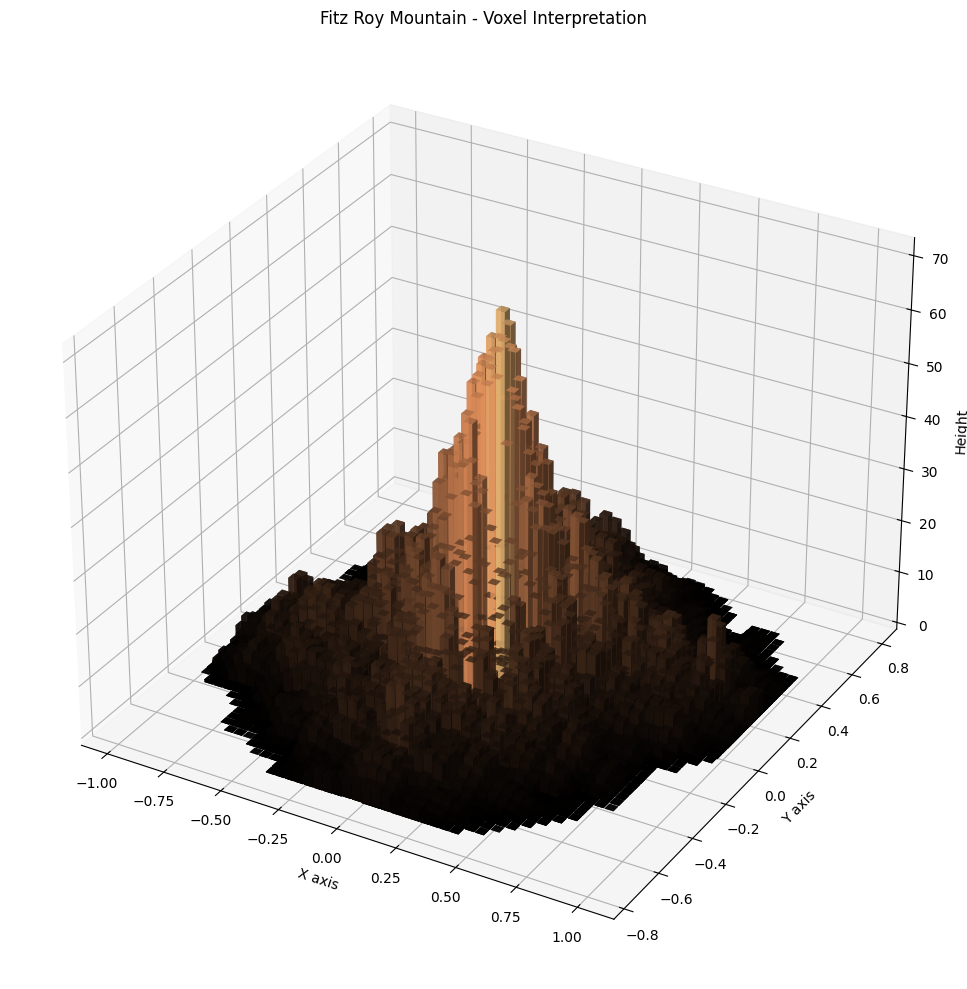

In [7]:
def generate_fitz_roy_mountain():
    # Import necessary libraries
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from scipy.interpolate import RegularGridInterpolator
    from scipy.ndimage import gaussian_filter
    
    # Create a grid for our base terrain
    grid_size = 50
    x = np.linspace(-3, 3, grid_size)
    y = np.linspace(-3, 3, grid_size)
    xx, yy = np.meshgrid(x, y)
    
    # Initialize an empty height map
    height_map = np.zeros((grid_size, grid_size))
    
    # Create the main Fitz Roy peak (taller and sharper than regular mountains)
    r = np.sqrt((xx)**2 + (yy)**2)
    main_peak = np.exp(-r**2 / 0.5)  # Narrower base for sharper peak
    main_peak = main_peak ** 2.5     # Raise to power for sharper falloff
    
    # Create the jagged ridgeline characteristic of Fitz Roy
    # Add several smaller, sharp peaks along a ridge
    num_peaks = 5
    peak_positions = np.linspace(-0.7, 0.7, num_peaks)
    
    for i, pos in enumerate(peak_positions):
        # Vary the height of each peak
        peak_height = 0.65 + 0.35 * np.sin(i * np.pi / (num_peaks-1))
        if i == num_peaks // 2:  # Make the middle peak the tallest
            peak_height = 1.0
            
        # Create each jagged peak
        peak_x = pos
        peak_y = pos * 0.2  # Slight curve to the ridge
        r_peak = np.sqrt((xx - peak_x)**2 + (yy - peak_y)**2)
        peak = peak_height * np.exp(-r_peak**2 / 0.15)  # Sharper, smaller peaks
        peak = peak ** 3.0  # Very sharp falloff for jagged appearance
        
        # Add to the height map
        height_map = np.maximum(height_map, peak)
    
    # Add the main central peak (tallest)
    height_map = np.maximum(height_map, main_peak)
    
    # Add some noise/texture to simulate the rough granite surface
    texture = 0.1 * np.random.rand(grid_size, grid_size)
    texture = gaussian_filter(texture, sigma=1.0)
    
    # Only add texture where there's already mountain
    texture = texture * (height_map > 0.1)
    height_map = height_map + texture
    
    # Generate 3D data from the height map
    data = []
    for i in range(grid_size):
        for j in range(grid_size):
            if height_map[i, j] > 0.05:  # Threshold to avoid very small values
                # Add points with height proportional to the height map
                height = height_map[i, j]
                num_points = int(height * 200)  # More points for higher areas
                for _ in range(num_points):
                    x_pos = x[j] + 0.05 * np.random.randn()
                    y_pos = y[i] + 0.05 * np.random.randn()
                    z_pos = height * 3.0  # Scale height for dramatic effect
                    data.append([x_pos, y_pos, z_pos])
    
    data = np.array(data)
    
    # Create histogram
    hist, edges = np.histogramdd(data, bins=(25, 25, 40))
    
    # Get original bin centers
    x_centers = edges[0][:-1] + (edges[0][1] - edges[0][0]) / 2
    y_centers = edges[1][:-1] + (edges[1][1] - edges[1][0]) / 2
    z_centers = edges[2][:-1] + (edges[2][1] - edges[2][0]) / 2
    
    # Create high-resolution grid
    sub_divisions = 2
    x_fine = np.linspace(edges[0][0], edges[0][-1], 25 * sub_divisions)
    y_fine = np.linspace(edges[1][0], edges[1][-1], 25 * sub_divisions)
    z_fine = np.linspace(edges[2][0], edges[2][-1], 40 * sub_divisions)
    
    # Set up interpolation
    interp_func = RegularGridInterpolator((x_centers, y_centers, z_centers),
                                          hist,
                                          bounds_error=False,
                                          fill_value=0)
    
    # Prepare coordinate arrays for high-resolution grid
    x_mesh, y_mesh, z_mesh = np.meshgrid(x_fine, y_fine, z_fine, indexing='ij')
    points = np.vstack([x_mesh.flatten(), y_mesh.flatten(), z_mesh.flatten()]).T
    
    # Interpolate values
    high_res_values = interp_func(points)
    
    # Add small variations for texture
    variation_factor = 0.03
    variations = 1 + variation_factor * (2 * np.random.random(high_res_values.shape) - 1)
    high_res_values = high_res_values * variations
    
    # Reshape back to grid
    high_res_hist = high_res_values.reshape(len(x_fine), len(y_fine), len(z_fine))
    
    # Prepare the coordinates for the bars
    x_pos, y_pos, z_pos, heights = [], [], [], []
    
    # Extract coordinates and heights for plotting
    for i in range(len(x_fine)):
        for j in range(len(y_fine)):
            for k in range(len(z_fine)):
                if high_res_hist[i, j, k] > 0.01:
                    x_pos.append(x_fine[i])
                    y_pos.append(y_fine[j])
                    z_pos.append(z_fine[k])
                    heights.append(high_res_hist[i, j, k])
    
    # Convert to numpy arrays
    x_pos = np.array(x_pos)
    y_pos = np.array(y_pos)
    z_pos = np.array(z_pos)
    heights = np.array(heights)
    
    # Create a 3D bar plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Calculate dimensions for the bars
    dx = (x_fine[1] - x_fine[0]) * 0.9
    dy = (y_fine[1] - y_fine[0]) * 0.9
    
    # Create colors - using a granite-like color scheme
    # Fitz Roy is known for its reddish color especially at sunrise/sunset
    granite_colors = plt.cm.copper(heights / max(heights))
    
    # Plot the bars
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, heights, color=granite_colors, alpha=0.8)
    
    # Set the viewing angle to highlight the jagged peaks
    ax.view_init(30, -60)
    
    # Set labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Height')
    ax.set_title('Fitz Roy Mountain - Voxel Interpretation')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    generate_fitz_roy_mountain()

NameError: name 'Image' is not defined

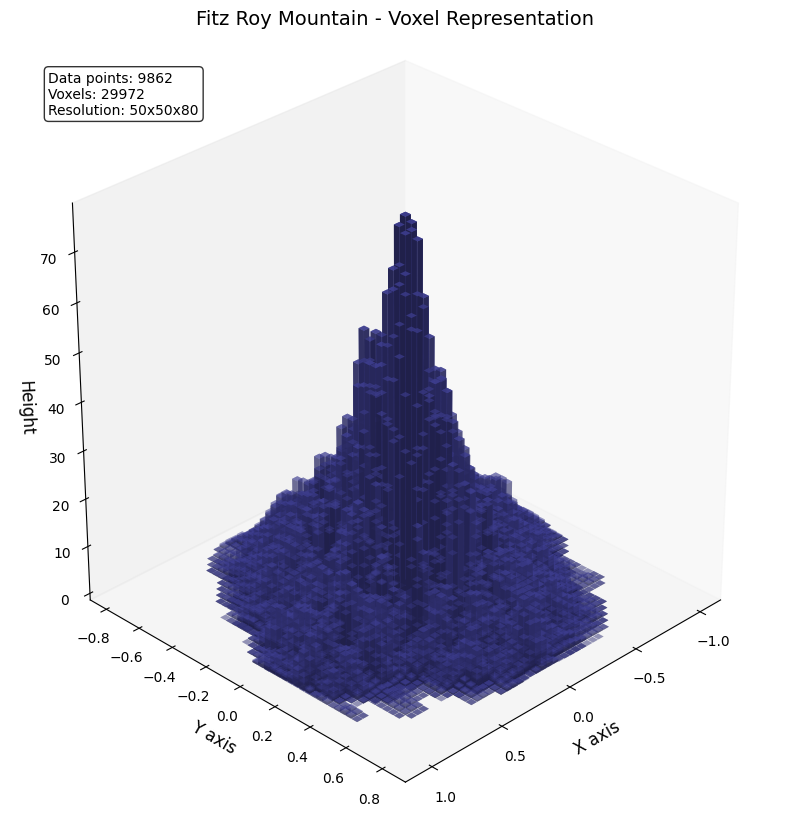

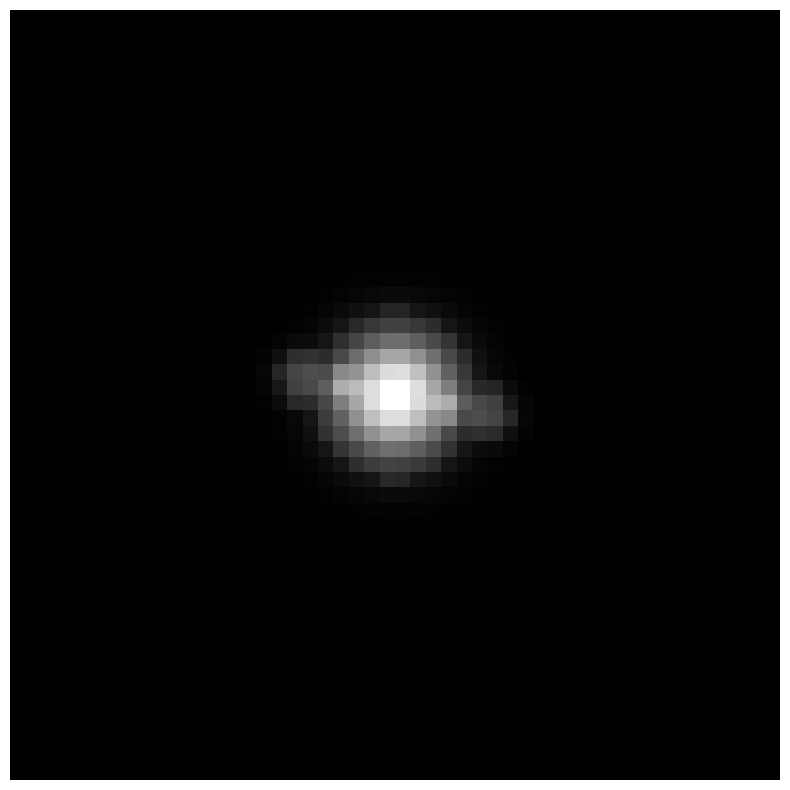

In [8]:
def generate_fitz_roy_mountain():
    # Import necessary libraries
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from scipy.interpolate import RegularGridInterpolator
    from scipy.ndimage import gaussian_filter
    
    # Create a grid for our base terrain
    grid_size = 50
    x = np.linspace(-3, 3, grid_size)
    y = np.linspace(-3, 3, grid_size)
    xx, yy = np.meshgrid(x, y)
    
    # Initialize an empty height map
    height_map = np.zeros((grid_size, grid_size))
    
    # Create the main Fitz Roy peak (taller and sharper than regular mountains)
    r = np.sqrt((xx)**2 + (yy)**2)
    main_peak = np.exp(-r**2 / 0.5)  # Narrower base for sharper peak
    main_peak = main_peak ** 2.5     # Raise to power for sharper falloff
    
    # Create the jagged ridgeline characteristic of Fitz Roy
    # Add several smaller, sharp peaks along a ridge
    num_peaks = 5
    peak_positions = np.linspace(-0.7, 0.7, num_peaks)
    
    for i, pos in enumerate(peak_positions):
        # Vary the height of each peak
        peak_height = 0.65 + 0.35 * np.sin(i * np.pi / (num_peaks-1))
        if i == num_peaks // 2:  # Make the middle peak the tallest
            peak_height = 1.0
            
        # Create each jagged peak
        peak_x = pos
        peak_y = pos * 0.2  # Slight curve to the ridge
        r_peak = np.sqrt((xx - peak_x)**2 + (yy - peak_y)**2)
        peak = peak_height * np.exp(-r_peak**2 / 0.15)  # Sharper, smaller peaks
        peak = peak ** 3.0  # Very sharp falloff for jagged appearance
        
        # Add to the height map
        height_map = np.maximum(height_map, peak)
    
    # Add the main central peak (tallest)
    height_map = np.maximum(height_map, main_peak)
    
    # Add some noise/texture to simulate the rough granite surface
    texture = 0.1 * np.random.rand(grid_size, grid_size)
    texture = gaussian_filter(texture, sigma=1.0)
    
    # Only add texture where there's already mountain
    texture = texture * (height_map > 0.1)
    height_map = height_map + texture
    
    # Generate 3D data from the height map
    data = []
    for i in range(grid_size):
        for j in range(grid_size):
            if height_map[i, j] > 0.05:  # Threshold to avoid very small values
                # Add points with height proportional to the height map
                height = height_map[i, j]
                num_points = int(height * 200)  # More points for higher areas
                for _ in range(num_points):
                    x_pos = x[j] + 0.05 * np.random.randn()
                    y_pos = y[i] + 0.05 * np.random.randn()
                    z_pos = height * 3.0  # Scale height for dramatic effect
                    data.append([x_pos, y_pos, z_pos])
    
    data = np.array(data)
    
    # Create histogram
    hist, edges = np.histogramdd(data, bins=(25, 25, 40))
    
    # Get original bin centers
    x_centers = edges[0][:-1] + (edges[0][1] - edges[0][0]) / 2
    y_centers = edges[1][:-1] + (edges[1][1] - edges[1][0]) / 2
    z_centers = edges[2][:-1] + (edges[2][1] - edges[2][0]) / 2
    
    # Create high-resolution grid
    sub_divisions = 2
    x_fine = np.linspace(edges[0][0], edges[0][-1], 25 * sub_divisions)
    y_fine = np.linspace(edges[1][0], edges[1][-1], 25 * sub_divisions)
    z_fine = np.linspace(edges[2][0], edges[2][-1], 40 * sub_divisions)
    
    # Set up interpolation
    interp_func = RegularGridInterpolator((x_centers, y_centers, z_centers),
                                          hist,
                                          bounds_error=False,
                                          fill_value=0)
    
    # Prepare coordinate arrays for high-resolution grid
    x_mesh, y_mesh, z_mesh = np.meshgrid(x_fine, y_fine, z_fine, indexing='ij')
    points = np.vstack([x_mesh.flatten(), y_mesh.flatten(), z_mesh.flatten()]).T
    
    # Interpolate values
    high_res_values = interp_func(points)
    
    # Add small variations for texture
    variation_factor = 0.03
    variations = 1 + variation_factor * (2 * np.random.random(high_res_values.shape) - 1)
    high_res_values = high_res_values * variations
    
    # Reshape back to grid
    high_res_hist = high_res_values.reshape(len(x_fine), len(y_fine), len(z_fine))
    
    # Prepare the coordinates for the bars
    x_pos, y_pos, z_pos, heights = [], [], [], []
    
    # Extract coordinates and heights for plotting
    for i in range(len(x_fine)):
        for j in range(len(y_fine)):
            for k in range(len(z_fine)):
                if high_res_hist[i, j, k] > 0.01:
                    x_pos.append(x_fine[i])
                    y_pos.append(y_fine[j])
                    z_pos.append(z_fine[k])
                    heights.append(high_res_hist[i, j, k])
    
    # Convert to numpy arrays
    x_pos = np.array(x_pos)
    y_pos = np.array(y_pos)
    z_pos = np.array(z_pos)
    heights = np.array(heights)
    
    # Create a 3D bar plot with a more minimalist scientific style
    plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a more common font
    
    fig = plt.figure(figsize=(12, 10), facecolor='white')
    ax = fig.add_subplot(111, projection='3d')
    
    # Set background color to white for clean scientific look
    ax.set_facecolor('white')
    
    # Calculate dimensions for the bars
    dx = (x_fine[1] - x_fine[0]) * 0.9
    dy = (y_fine[1] - y_fine[0]) * 0.9
    
    # Create a minimalist monochromatic color scheme
    # Using a single color with varying alpha for depth perception
    # This creates a more "scientific plot" aesthetic
    base_color = (0.3, 0.3, 0.7, 0.8)  # Blue-ish base color
    
    # Create colors based on height - monochromatic with transparency
    color_array = np.zeros((len(heights), 4))
    normalized_heights = heights / max(heights)
    
    for i in range(len(heights)):
        # Vary only the alpha and brightness based on height
        color_array[i, 0] = base_color[0]  # R
        color_array[i, 1] = base_color[1]  # G
        color_array[i, 2] = base_color[2]  # B
        color_array[i, 3] = 0.3 + 0.7 * normalized_heights[i]  # Alpha varies with height
    
    # Plot the bars
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, heights, color=color_array, shade=True)
    
    # Adjust viewing angle for better visualization
    ax.view_init(30, 45)
    
    # Clean up the plot - remove grid for minimalist look
    ax.grid(False)
    
    # Set a tight aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    # Set labels with standard font
    ax.set_xlabel('X axis', fontsize=12)
    ax.set_ylabel('Y axis', fontsize=12)
    ax.set_zlabel('Height', fontsize=12)
    
    # Add a title with scientific styling
    plt.title('Fitz Roy Mountain - Voxel Representation', fontsize=14)
    
    # Add stats text box for scientific feel
    ax.text2D(0.05, 0.95, 
              f"Data points: {len(data)}\nVoxels: {len(heights)}\nResolution: {len(x_fine)}x{len(y_fine)}x{len(z_fine)}", 
              transform=ax.transAxes, 
              fontsize=10, 
              verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Save the heightmap for use in Godot (saving an 8-bit version as well for broader compatibility)
    plt.figure(figsize=(10, 10))
    plt.imshow(height_map, cmap='gray')
    plt.axis('off')
    plt.savefig("fitz_roy_heightmap_8bit.png", bbox_inches='tight', pad_inches=0, dpi=300)

    # Save the heightmap as 16-bit grayscale PNG
    height_map_scaled = ((height_map - np.min(height_map)) / (np.max(height_map) - np.min(height_map))) * 65535
    height_map_uint16 = height_map_scaled.astype(np.uint16)
    img_16bit = Image.fromarray(height_map_uint16)
    img_16bit.save("fitz_roy_heightmap_16bit.png")

    # Set tight layout and show the 3D plot
    plt.tight_layout()
    plt.savefig("fitz_roy_mountain_plot.png", dpi=300)
    plt.show()

    return height_map, fig

if __name__ == "__main__":
    height_map, fig = generate_fitz_roy_mountain()

In [ ]:
from PIL import Image

def get_png_bit_depth_robust(image_path):
    """
    Checks the bit depth of a PNG image using Pillow (more robust).

    Args:
        image_path (str): The path to the PNG image file.

    Returns:
        str: A string describing the bit depth (e.g., '8-bit', '16-bit'),
             or None if the information cannot be reliably determined.
    """
    try:
        img = Image.open(image_path)
        mode = img.mode
        info = img.info

        if 'P' in mode:  # Paletted image
            return '8-bit (paletted)'
        elif 'I;16' in mode or 'RGB;16' in mode or 'RGBA;16' in mode:
            return '16-bit'
        elif 'L' in mode:
            if 'bitdepth' in info and info['bitdepth'] == 8:
                return '8-bit (grayscale)'
            else:
                return '8-bit (likely grayscale)' # Default assumption for 'L'
        elif 'RGB' in mode or 'RGBA' in mode:
            if 'bitdepth' in info and info['bitdepth'] == 8:
                return '8-bit (color)'
            else:
                return '8-bit (likely color)' # Default assumption for 'RGB/RGBA'
        elif 'bitdepth' in info:
            return f"{info['bitdepth']}-bit"
        else:
            return None

    except FileNotFoundError:
        print(f"Error: File not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

if __name__ == "__main__":
    png_file = 'fitz_roy_heightmap_16bit.png'  # Use your actual file name
    bit_depth = get_png_bit_depth_robust(png_file)
    if bit_depth:
        print(f"The PNG image '{png_file}' is likely {bit_depth}.")
    else:
        print(f"Could not reliably determine the bit depth of '{png_file}'.")

The PNG image 'fitz_roy_heightmap_16bit.png' is likely 16-bit.


In [ ]:
import open3d as o3d

height = imageio.imread('fitz_roy_heightmap_16bit.png')
height = height.astype(np.uint16)


def generate_3d_mesh_from_heightmap(heightmap_path, vertex_scale=0.1, z_scale=1.0, invert_y=False):
    """
    Generates a 3D mesh from a heightmap image using Open3D.

    Args:
        heightmap_path (str): Path to the heightmap image (e.g., PNG).
        vertex_scale (float): Scaling factor for the X and Y coordinates.
        z_scale (float): Scaling factor for the Z (vertical) coordinate.
        invert_y (bool): If True, inverts the Y-axis (useful for some coordinate systems).

    Returns:
        open3d.geometry.TriangleMesh: The generated 3D mesh.
    """
    # 1. Load the heightmap image
    try:
        heightmap_img = Image.open(heightmap_path)
    except FileNotFoundError:
        print(f"Error: Heightmap image not found at {heightmap_path}")
        return None
    heightmap = np.array(heightmap_img)

    # 2. Get dimensions
    height, width = heightmap.shape

    # 3. Create vertices
    vertices = np.zeros((height * width, 3))
    for y in range(height):
        for x in range(width):
            # Calculate vertex positions, scaling X and Y
            x_scaled = x * vertex_scale
            y_scaled = y * vertex_scale
            z_scaled = heightmap[y, x] * z_scale
            if invert_y:
                y_scaled = -y_scaled
            vertices[(y * width) + x] = [x_scaled, y_scaled, z_scaled]

    # 4. Create triangles (indices)
    indices = []
    for y in range(height - 1):
        for x in range(width - 1):
            # Define the indices for two triangles forming a quad
            i1 = (y * width) + x
            i2 = (y * width) + (x + 1)
            i3 = ((y + 1) * width) + x
            i4 = ((y + 1) * width) + (x + 1)
            # First triangle
            indices.append([i1, i2, i3])
            # Second triangle
            indices.append([i2, i4, i3])
    triangles = np.array(indices)

    # 5. Create the Open3D TriangleMesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)

    # 6. (Optional) Calculate normals for proper shading
    mesh.compute_vertex_normals()

    return mesh

def save_mesh(mesh, output_path, binary=True):
    """
    Saves an Open3D TriangleMesh to a file.

    Args:
        mesh (open3d.geometry.TriangleMesh): The mesh to save.
        output_path (str): Path to save the mesh (e.g., .obj, .stl, .ply).
        binary (bool): If True, save in binary format (smaller file size).
    """
    o3d.io.write_triangle_mesh(output_path, mesh, write_triangle_indices=True, write_vertex_normals=True, write_vertex_colors=False, write_textured_vertex_colors=False, write_ascii=not binary, write_bigendian=False, write_vertex_uvs=False, write_point_colors=False)
    print(f"Mesh saved to {output_path}")

if __name__ == "__main__":
    # 1. Provide the path to your heightmap image
    heightmap_file = "your_heightmap.png"  # Replace with your heightmap file

    # 2. Set scaling factors (adjust as needed)
    vertex_scale = 0.1  # Adjust to scale the X and Y dimensions of the terrain
    z_scale = 0.05      # Adjust to control the vertical exaggeration of the terrain
    invert_y = False # Set to True if your Y axis needs to be inverted

    # 3. Generate the 3D mesh
    mesh = generate_3d_mesh_from_heightmap(heightmap_file, vertex_scale, z_scale, invert_y)

    # 4. Save the mesh to a file (choose a format Godot supports)
    if mesh is not None:
        output_file = "terrain_mesh.obj"  # Or "terrain_mesh.stl", "terrain_mesh.ply"
        save_mesh(mesh, output_file)

        # 5. (Optional) Visualize the mesh
        o3d.visualization.draw_geometries([mesh]) #comment this out if you don't want to visualize



ModuleNotFoundError: No module named 'open3d'